<a href="https://colab.research.google.com/github/siva-sankar-a/eva/blob/master/S6/EVA4_Session_6_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S5 _Assignment 6_

  | Summary of overall targets |  |
  | - | - |
  | _Dataset_| **MNIST** |
  | _Max. number of epochs_| **40** |
  | _Max. number of parameters_| **10K** |


# Implementation

## Initialization

### Mounting google drive to save results

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Import and install all required libraries

In [0]:
!pip install torchsummary
!pip install torchviz
!pip install receptivefield>=0.5.0

import datetime
import glob

import numpy as np
import pandas as pd
import cv2

from __future__ import print_function        # Import for print statement
import torch                                 # Import pytorch library
import torch.nn as nn                        # Import neural net module from pytorch
import torch.nn.functional as F              # Import functional interface from pytorch
import torch.optim as optim                  # Import optimizer module from pytorch

from torchvision import datasets, transforms # Import datasets and augmentation functionality from vision module within pytorch
from torchsummary import summary             # Import summary with pytorch
from torchviz import make_dot

from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable

import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm

from torch.optim.lr_scheduler import StepLR

     |████████████████████████████████| 51kB 8.2MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=32767d2841df795c3d56c89ecfc8630221e48bb85a10f7dd2359318d0bdcebe2
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [0]:
use_cuda = torch.cuda.is_available()                  # Check cuda avaliability

In [0]:
SEED = 1

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)

## Load MNIST Dataset

### Initialize _transforms_, _dataset_ & _dataloader_

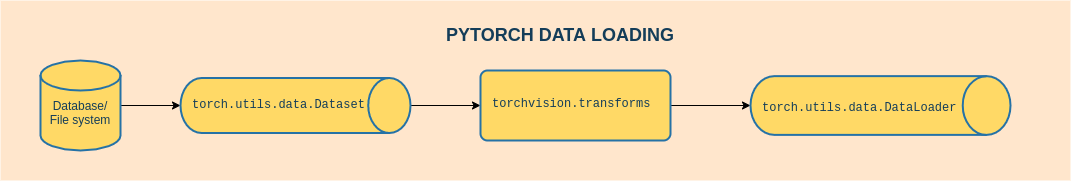

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       # transforms.Resize((28, 28)),
                                       # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       # transforms.Resize((28, 28)),
                                       # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
batch_size = 64

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=batch_size)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

## Experiment

###Model

In [0]:
# Subclassing nn.Module for neural networks
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #########################################################################################
        # INPUT BLOCK
        #########################################################################################
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8), 
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        #########################################################################################
        # CONVOLUTION BLOCK 1
        #########################################################################################
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        #########################################################################################
        # TRANSITION BLOCK 1
        #########################################################################################
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        #########################################################################################
        # CONVOLUTION BLOCK 2
        #########################################################################################
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        #########################################################################################
        # GAP BLOCK
        #########################################################################################
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
        )
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )
        #########################################################################################
        #----------------------------------------------------------------------------------------
        # OUTPUT SIZE = 1
        #----------------------------------------------------------------------------------------
        #########################################################################################
        # OUTPUT BLOCK
        #########################################################################################
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

###Summary

####Textual summary

In [0]:
device = torch.device("cuda" if use_cuda else "cpu") # Initializing GPU
model = Net().to(device)                             # Initializing model and transfering to GPU
summary(model, input_size=(1, 28, 28))

TypeError: ignored

####Graphical summary

In [0]:
random_input = torch.randn(1, 1, 28, 28).cuda() if use_cuda else torch.randn(1, 1, 28, 28) 
model.eval()
y = model(Variable(random_input))
dot_graph = make_dot(y)
dot_graph.format = 'svg'
dot_graph.render(f'model_architecture')
dot_graph

### Training

#### Training routine

In [0]:
def train(model, device, train_loader, optimizer, epoch, writer, regularization=None, weight_decay=0.01):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)
    train_len = len(train_loader.dataset)

    for batch_idx, (data, target) in enumerate(pbar):
        
        # Move data to cpu/gpu based on input
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        
        # Loss computation
        batch_loss = F.nll_loss(output, target)
        train_loss += batch_loss  # sum up batch loss
        

        # Regularization
        if regularization == 'L1' or regularization == 'L1 and L2':
          l1_loss = nn.L1Loss(reduction='sum')
          regularization_loss = 0
          for param in model.parameters():
            regularization_loss += l1_loss(param, target=torch.zeros_like(param))
          train_loss += weight_decay * regularization_loss # regularization loss
        
        # Predictions
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        # Backward pass
        batch_loss.backward()
        
        # Gradient descent
        optimizer.step()

        # Logging - updating progress bar and summary writer
        pbar.set_description(desc= f'TRAIN : epoch={epoch} train_loss={(train_loss / train_len):.5f} correct/total={correct}/{train_len} accuracy={(100. * correct / train_len):.2f}')
        writer.add_scalar('train/batch_loss', batch_loss, epoch * train_len + batch_idx)
    
    train_loss /= train_len
    train_accuracy = 100. * correct / train_len
    writer.add_scalar('loss', train_loss, epoch)
    writer.add_scalar('accuracy', train_accuracy, epoch)

#### Testing routine

In [0]:
def test(model, device, test_loader, epoch, writer, regularization=None, weight_decay=0.01):
    model.eval()
    test_loss = 0
    correct = 0
    pbar = tqdm(test_loader)
    test_len = len(test_loader.dataset)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):

            # Move data to cpu/gpu based on input
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Loss computation
            batch_loss = F.nll_loss(output, target, reduction='sum').item()
            test_loss += batch_loss

            # Predictions
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Logging - updating progress bar and summary writer
            pbar.set_description(desc= f'TEST :  epoch={epoch} test_loss={(test_loss / test_len):.5f} correct/total={correct}/{test_len} accuracy=\033[1m{(100. * correct / test_len):.2f}\033[0m')
            writer.add_scalar('test/batch_loss', batch_loss, epoch * test_len + batch_idx)

    test_loss /= test_len
    test_accuracy = 100. * correct / test_len
    writer.add_scalar('loss', test_loss, epoch)
    writer.add_scalar('accuracy', test_accuracy, epoch)

### Execution

In [0]:
def optimize(model, epochs=40, momentum=0.9, lr=0.01, regularization=None, weight_decay=0.01, experiment_name='experiment_name_1'):
  now = datetime.datetime.now()
  prefix = now.strftime('%m-%d-%y %H:%M:%S')

  train_dir_suffix = f'/content/drive/My Drive/log_mnist_s6/run_train_{experiment_name}'
  test_dir_suffix = f'/content/drive/My Drive/log_mnist_s6/run_test_{experiment_name}'

  train_dir = f'{train_dir_suffix}_{prefix}'
  test_dir = f'{test_dir_suffix}_{prefix}'

  train_writer = SummaryWriter(train_dir)
  test_writer = SummaryWriter(test_dir)

  if regularization == 'L2' or regularization == 'L1 and L2':
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
  else:
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

  scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

  for epoch in range(0, epochs):
      train(model, device, train_loader, optimizer, epoch, train_writer, regularization, weight_decay)
      test(model, device, test_loader, epoch, test_writer, regularization, weight_decay)
      scheduler.step()

In [0]:
for regularization in [None, 'L1', 'L2', 'L1 and L2']:
  for weight_decay in [1e-1, 1e-3, 1e-6]:

In [0]:
models = {}
experiments = []
for regularization in ['L1', 'L2']:
  for weight_decay in [1e-6]:
    experiment = f's6_{regularization if regularization else "no"}_reg_{weight_decay:1.0e}'
    model = Net().to(device)
    lr = 0.01
    epochs = 40
    momentum = 0.9
    weight_decay = weight_decay
    optimize(model, epochs, momentum, lr, regularization, weight_decay, experiment)
    experiments.append(experiment)
    models[experiment] = model

TRAIN : epoch=0 train_loss=0.00726 correct/total=52605/60000 accuracy=87.67: 100%|██████████| 938/938 [00:22<00:00, 42.54it/s]
TEST :  epoch=0 test_loss=0.05602 correct/total=9857/10000 accuracy=98.57: 100%|██████████| 157/157 [00:02<00:00, 68.77it/s]
TRAIN : epoch=1 train_loss=0.00140 correct/total=58511/60000 accuracy=97.52: 100%|██████████| 938/938 [00:21<00:00, 43.98it/s]
TEST :  epoch=1 test_loss=0.03809 correct/total=9895/10000 accuracy=98.95: 100%|██████████| 157/157 [00:02<00:00, 68.89it/s]
TRAIN : epoch=2 train_loss=0.00105 correct/total=58855/60000 accuracy=98.09: 100%|██████████| 938/938 [00:21<00:00, 53.99it/s]
TEST :  epoch=2 test_loss=0.03225 correct/total=9898/10000 accuracy=98.98: 100%|██████████| 157/157 [00:02<00:00, 67.79it/s]
TRAIN : epoch=3 train_loss=0.00091 correct/total=58943/60000 accuracy=98.24: 100%|██████████| 938/938 [00:21<00:00, 41.33it/s]
TEST :  epoch=3 test_loss=0.03153 correct/total=9901/10000 accuracy=99.01: 100%|██████████| 157/157 [00:02<00:00, 65.

# Outputs

## Loss and accuracy

In [0]:
def get_test_train_logs(experiment_name):
  train_dir_suffix = f'/content/drive/My Drive/log_mnist_s6/run_train_{experiment_name}'
  test_dir_suffix = f'/content/drive/My Drive/log_mnist_s6/run_test_{experiment_name}'

  train_1 = glob.glob(f'{train_dir_suffix}_*/events.out.tfevents.*')[-1]
  test_1 = glob.glob(f'{test_dir_suffix}_*/events.out.tfevents.*')[-1]

  experiment_data = {experiment_name: (train_1, test_1)}

  for experiment, (train, test) in experiment_data.items():
    train_data = {}
    test_data = {}
    for e in tf.compat.v1.train.summary_iterator(train):
        for v in e.summary.value:
            if v.tag not in train_data:
                train_data[v.tag] = []
            train_data[v.tag].append(v.simple_value)
    for e in tf.compat.v1.train.summary_iterator(test):
          for v in e.summary.value:
              if v.tag not in test_data:
                  test_data[v.tag] = []
              test_data[v.tag].append(v.simple_value)
  
  return train_data, test_data

In [0]:
experiments = []
for regularization in [None, 'L1', 'L2', 'L1 and L2']:
  for weight_decay in [1e-6]:
    experiment = f's6_{regularization if regularization else "no"}_reg_{weight_decay:1.0e}'
    experiments.append(experiment)

In [0]:
summary = {}
for experiment in experiments:
  summary[experiment] = {}
  train_data, test_data = get_test_train_logs(experiment)
  summary[experiment]['train'] = train_data
  summary[experiment]['test'] = test_data

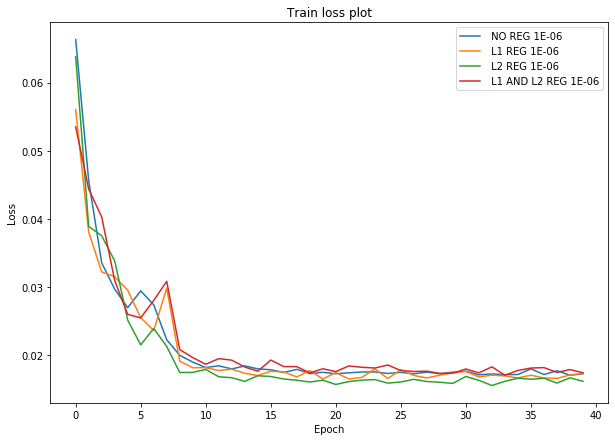

In [0]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))

legends = []

axs.set_title(f'Train loss plot')

for experiment in experiments:
  axs.plot(summary[experiment]['test']['loss'])
  axs.set_ylabel('Loss')
  axs.set_xlabel('Epoch')
  legends.append(experiment.replace('s6', '').replace('_', ' ').upper())

axs.legend(legends, loc='best')

plt.savefig('/content/drive/My Drive/log_mnist_s6/test-loss-curve.jpg')
plt.show()

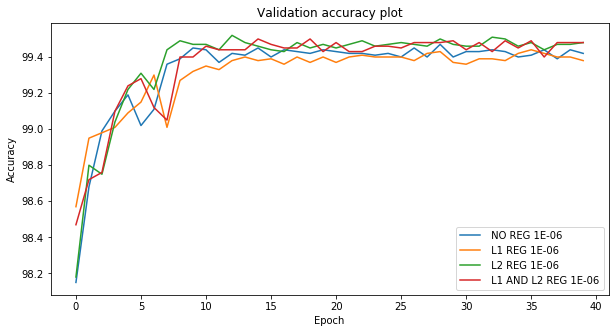

In [0]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

axs.set_title(f'Validation accuracy plot')

legends = []

for experiment in experiments:
  axs.plot(summary[experiment]['test']['accuracy'])
  axs.set_ylabel('Accuracy')
  axs.set_xlabel('Epoch')
  legends.append(experiment.replace('s6', '').replace('_', ' ').upper())

axs.legend(legends, loc='best')

plt.savefig('/content/drive/My Drive/log_mnist_s6/validation-accuracy-curve.jpg')
plt.show()

## Get mis-classified

In [0]:
def get_mis_classified(model, no_of_images=25):
  train_loader_iterator = iter(train_loader)
  fail_count = 0
  failed_samples = []
  while fail_count < no_of_images:
    data, target = train_loader_iterator.next()
    data, target = data.to(device), target.to(device)

    output = model(data)

    pred = output.argmax(dim=1, keepdim=True)
    failed_index = ~pred.eq(target.view_as(pred)).squeeze()

    failed_data = data[failed_index]
    failed_target = target[failed_index]
    failed_prediction = pred[failed_index]
    
    batch_fail_count = failed_data.size(dim=0)
    fail_count += batch_fail_count

    for count in range(batch_fail_count):
      failed_sample = {
          'data': failed_data[count].view(28, 28).cpu().numpy(),
          'target': failed_target[count],
          'prediction': failed_prediction[count].item()
      }

      failed_samples.append(failed_sample)

  return failed_samples

### L1 mis-classified

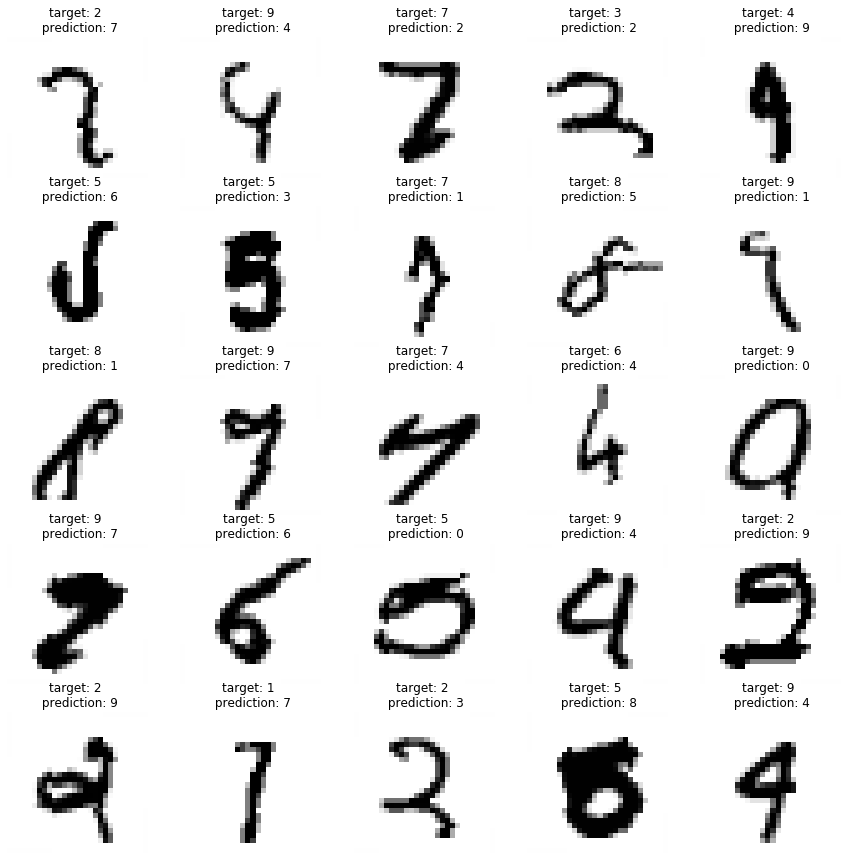

In [0]:
figure = plt.figure(figsize=(15, 15))
num_of_images = 25
failed_samples = get_mis_classified(models['s6_L1_reg_1e-06'], num_of_images)
for index in range(1, num_of_images + 1):
    ax = plt.subplot(5, 5, index)
    plt.axis('off')
    plt.imshow(failed_samples[index - 1]['data'], cmap='gray_r')
    ax.set_title(f"target: {failed_samples[index - 1]['target']} \n prediction: {failed_samples[index - 1]['prediction']}")
plt.savefig('/content/drive/My Drive/log_mnist_s6/failed-l1.jpg')

### L2-misclassified

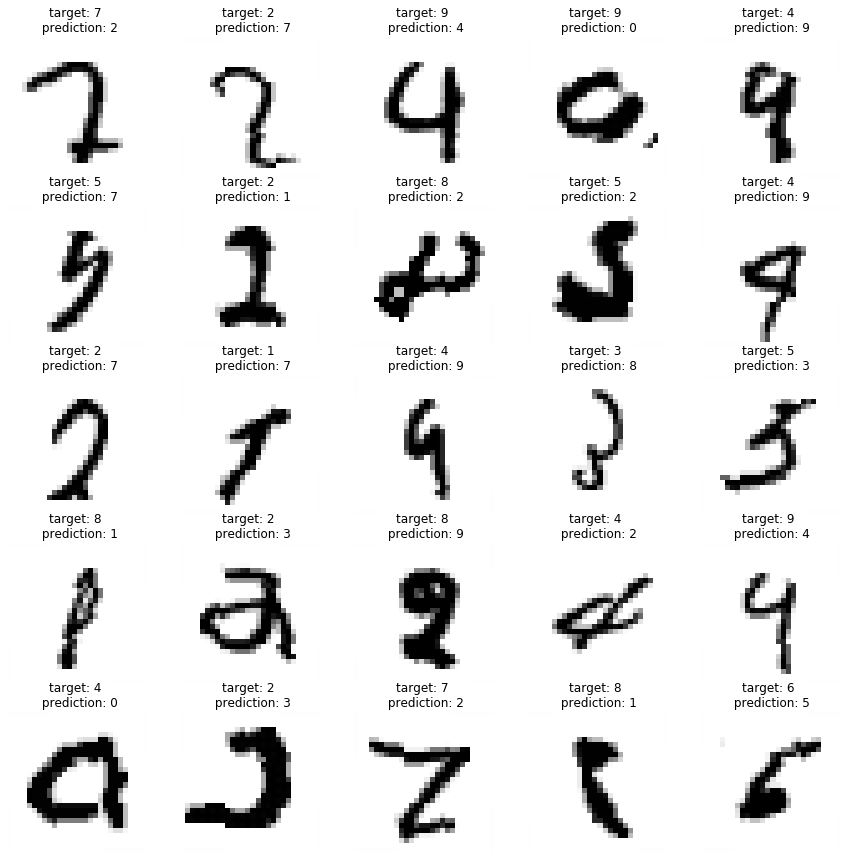

In [0]:
figure = plt.figure(figsize=(15, 15))
num_of_images = 25
failed_samples = get_mis_classified(models['s6_L2_reg_1e-06'], num_of_images)
for index in range(1, num_of_images + 1):
    ax = plt.subplot(5, 5, index)
    plt.axis('off')
    plt.imshow(failed_samples[index - 1]['data'], cmap='gray_r')
    ax.set_title(f"target: {failed_samples[index - 1]['target']} \n prediction: {failed_samples[index - 1]['prediction']}")
plt.savefig('/content/drive/My Drive/log_mnist_s6/failed-l2.jpg')

# Target
 - Introduced LR - scheduler and image augmentation
  - LR scheduled to switch after 8th epoch

# Result
| Metric | Value |
| - | - |
| _Best train accuracy_| **99.05** |
| _Best test accuracy_| **99.46** |
| _Best epoch number_| **14** |
| _Parameter count_ | **9,608** |

# Analysis
 - Best network till now with consistent 99.4+ from epoch 10
 - LR scheduler working due to very high accuracy change after 8th epoch
 - No overfitting both train and test accuracies stay close to each other